# Gradient Descent: Quadratic forms and MMSE denoising

We'll investigate the use of gradient descent with two simple examples: optimizing a 2-d quadratic and denoising an image drawn from a multivariate Gaussian distribution.

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces
from sklearn.decomposition import PCA

# Load the faces datasets
faces = fetch_olivetti_faces()
images = faces.images
data = faces.data
targets = faces.target
image_shape = (64, 64)

To warm up, we'll optimize the simple function $f(x) = x^T A x$. This function is provably convex, and its global minimum is obviously $x=0$. But we'll see how gradient descent gets us there.

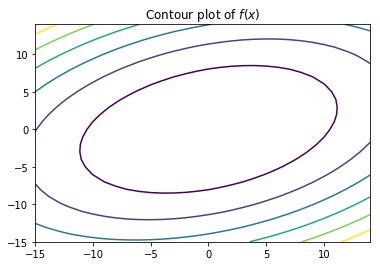

In [2]:
A = np.random.randn(2,2)
A = A@A.T

v_min = -15
v_max = 15
delta = 1
v1 = np.arange(v_min,v_max,delta)
v2 = np.arange(v_min,v_max,delta)
length = v2.size

X1, X2 = np.meshgrid(v1, v2)

x1 = np.array(X1).flatten()
x2 = np.array(X2).flatten()

X = np.stack((x1,x2))
F = np.diag(X.T@A@X).reshape(length,length)

plt.contour(X1,X2,F)
plt.title('Contour plot of $f(x)$')
plt.show()

Starting at $x_0 = (-15,15)$, let's see how gradient descent solves this problem iteratively.

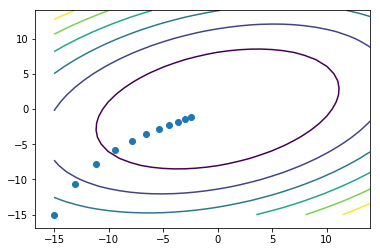

In [3]:
num_iterations = 10
alpha = 0.1

x = np.zeros([2,num_iterations+1])
x[:,0] = [-15,-15]

#carry out gradient descent iterations
for i in range(0,num_iterations):
    this_gradient = A@x[:,i]
    x[:,i+1] = x[:,i] - alpha*this_gradient
    
#plot the results! recreate the countour plot first
v_min = -15
v_max = 15
delta = 1
v1 = np.arange(v_min,v_max,delta)
v2 = np.arange(v_min,v_max,delta)
length = v2.size

X1, X2 = np.meshgrid(v1, v2)

x1 = np.array(X1).flatten()
x2 = np.array(X2).flatten()

X = np.stack((x1,x2))
F = np.diag(X.T@A@X).reshape(length,length)

plt.contour(X1,X2,F)
plt.scatter(x[0,:], x[1,:])
plt.show()

Next, we'll denoise an image drawn from a multivariate Gaussian. For fun, we'll choose a Gaussian distribution with a covariance drawn from the Olivetti face database that we looked at earlier. This uses the principal components analysis method mentioned earlier. Don't worry about the PCA details for now -- this is just code to give us an interesting covariance matrix. We'll dive deep into PCA later in the semester!

In [4]:
num_components = 5
pca = PCA(n_components=num_components)
pca.fit(data)

sigma_m = 0.001
U = pca.components_
K = U.T@U + sigma_m**2*(np.eye(64**2) - U.T@U)

Generate the signal according to the specified covariance and display it as an image. Note that this **isn't** an image from the database -- this is totally synthetic!

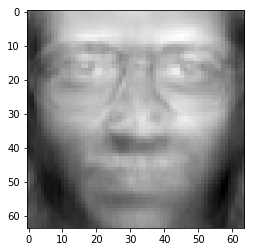

In [14]:
x = U.T@np.random.randn(num_components,1)
x_image = np.reshape(x,[64,64])
plt.imshow(x_image,cmap=plt.cm.gray,interpolation="nearest")
plt.show()

Now, we'll corrupt the image with Gaussian noise

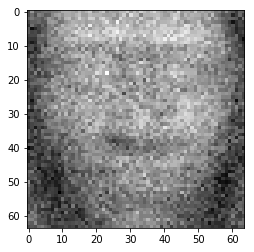

In [15]:
sigma = 0.01
noisy_x = x + sigma*np.random.randn(64**2,1)
noisy_x_image = np.reshape(noisy_x,[64,64])
plt.imshow(noisy_x_image,cmap=plt.cm.gray,interpolation="nearest")
plt.show()

To denoise the image, we'll carry out the **minimum mean squared error**, which is a Bayesian estimator that we'll study later in the semester. The associated function to minimize is $\frac{1}{2\sigma^2}||x - noisy x||^2 + \frac{1}{2}x^T K^{-1} x$. It has a simple closed-form solution, but for fun we'll use gradient descent to solve it anyways. We can compute the gradient of this pretty easily and take gradient steps to watch the noise diminish over time.

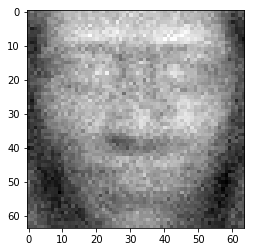

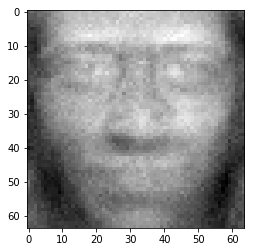

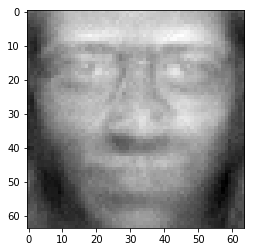

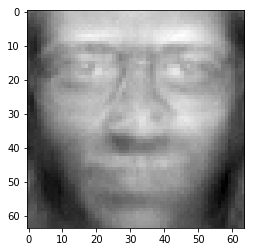

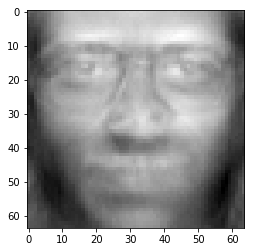

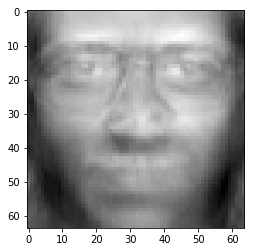

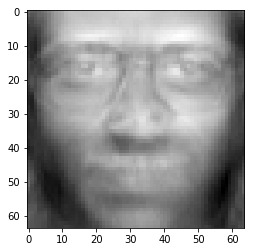

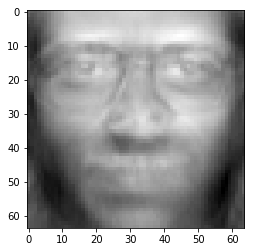

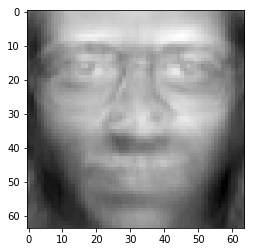

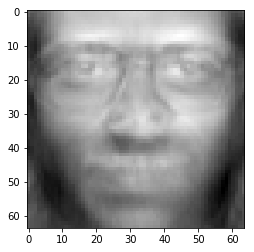

In [16]:
NUM_STEPS = 10
STOP_EVERY = 1
alpha = 0.000001

K_pinv = np.linalg.inv(K)

x_star = noisy_x #initialize the estimate at the noisy image

for i in range(0, NUM_STEPS//STOP_EVERY):
    for j in range(0,STOP_EVERY):
        this_gradient = 1/(sigma**2)*(x_star - noisy_x) + 1/2*K_pinv@x_star
        x_star = x_star - alpha*this_gradient
        x_star_image = np.resize(x_star,[64,64])    
    plt.imshow(x_star_image,cmap=plt.cm.gray,interpolation="nearest")
    plt.show()

A few things to notice here. Sure enough, taking gradient steps gradually reduces the noise. However, we had to set the stepsize *very* small. This is because the covariance matrix K has some very small eigenvalues, which become very large when we invert them. In order to prevent divergence, we have to be careful. In practice there isn't much you can do to avoid carefully tuning the stepsize.

As we mentioned, there is a closed form solution, which is $x^* = (I + sigma^2 K^{-1})^{-1})*noisyx$. Let's compute that quickly to see how well gradient descent got us to the MMSE estimator.

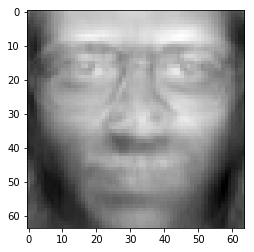

In [17]:
x_star = np.linalg.inv(np.eye(64**2) + sigma**2*np.linalg.inv(K))@noisy_x
x_star_image = np.resize(x_star,[64,64])
plt.imshow(x_star_image,cmap=plt.cm.gray,interpolation="nearest")
plt.show()